# Sparkify Spark Deployment
This project intends to use Sparkify user data to identify at-risk users who will likely churn.Full data (12GB) is used model training and hyperparameter tuning.

In [1]:
# Import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression,GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset

In [3]:
# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

In [4]:
# Print Schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Total sessions
print('Total activity records: ',df.count())

Total activity records:  286500


In [6]:
# Filter out status Guest and Logged Out to exclude guests
df_clean = df.filter((col('auth') == 'Cancelled') | (col('auth') == 'Logged In'))

In [7]:
# Count User
df_clean.agg(countDistinct('userId')).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [8]:
# Check for nulls
df_clean.filter(df_clean.userId == '').count()

0

In [9]:
df_clean.filter(df_clean.sessionId == '').count()

0

# Feature Engineering

In [10]:
# Get churn 1/0
cancel = udf(lambda auth: 1 if auth == 'Cancelled' else 0, IntegerType())
df_clean = df_clean.withColumn('cancel', cancel('auth'))

In [11]:
# Convert ts to date
df_feat = df_clean.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))

In [12]:
# Get date range
df_feat.select('date').agg(min('date')).show()

+----------+
| min(date)|
+----------+
|2018-10-01|
+----------+



In [13]:
df_feat.select('date').agg(max('date')).show()

+----------+
| max(date)|
+----------+
|2018-12-03|
+----------+



In [14]:
# User registration date
df_feat = df_feat.withColumn('date_created', F.to_date(F.from_unixtime(col('registration')/lit(1000))))

In [15]:
# Get user age at the activity date
df_feat = df_feat.withColumn('user_age',F.datediff(col('date'),col('date_created')))

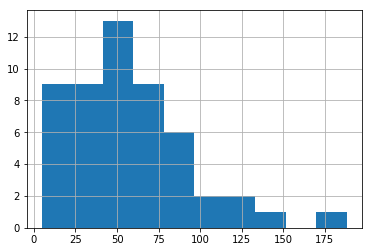

In [16]:
#User cancel by age
df_cancelled = df_feat.filter(col('cancel') == 1).select(['date','user_age','level']).toPandas()

df_cancelled['user_age'].hist()

In [17]:
# Get user interactions except for playing songs
inter = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend']
get_interactions = udf(lambda x: 1 if x in inter else 0, IntegerType())

# Get negative feedback from user
thumbs_down = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())

df_feat = df_feat.withColumn('interactions', get_interactions('page'))
df_feat = df_feat.withColumn('thumbs_down', thumbs_down('page'))

In [18]:
# Get number of songs played
songs = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
df_feat = df_feat.withColumn('songs', songs('page'))

In [19]:
# Has the user ever used paied service
paid_hist = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_feat = df_feat.withColumn('paid_hist', paid_hist('level'))

# Has the user ever downgraded
downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df_feat = df_feat.withColumn('downgraded', downgrade('page'))

In [20]:
# Convert gender to 1/0. 1 = female
female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df_feat = df_feat.withColumn('female', female('gender'))

In [21]:
# Get user level dimensions
dims = df_feat.groupby('userId','female','date_created').agg(\
                                                          max('user_age').alias('user_age'),\
                                                          max('paid_hist').alias('paid_user'),\
                                                          max('downgraded').alias('downgraded'),\
                                                          max('cancel').alias('canceled'))

In [22]:
# Inspect Dimensions
dims.take(1)

[Row(userId='142', female=0, date_created=datetime.date(2018, 9, 28), user_age=63, paid_user=1, downgraded=0, canceled=0)]

In [23]:
# Get measures based on usersessions and interactions
measures = df_feat.groupby('userId','sessionId').agg(\
                                                          min('date').alias('start_date'),\
                                                          max('date').alias('end_date'),\
                                                          sum('interactions').alias('interactions'),\
                                                          sum('thumbs_down').alias('thumbs_down'),\
                                                          sum('songs').alias('songs'),\
                                                          sum('length').alias('length'),\
                                                          countDistinct('artist').alias('c_artist'))

In [24]:
# Get the date gap between sessions
measures_lag = measures.withColumn('prev_end_date',
                        F.lag(col('end_date')).over(Window.partitionBy('userID').orderBy('start_date')))

measures_lag = measures_lag.withColumn('session_gap',\
                                      F.datediff(col('start_date'),col('prev_end_date')))

measures_agg = measures_lag.groupby('userId').agg(\
                                                 F.count('sessionId').alias('total_session'),\
                                                 avg('interactions').alias('interactions'),\
                                                 avg('thumbs_down').alias('thumbs_down'),\
                                                 avg('songs').alias('songs'),\
                                                 avg('length').alias('length'),\
                                                 avg('c_artist').alias('artists'),\
                                                 avg('session_gap').alias('session_gap'))

In [25]:
# Inspect measures
measures_agg.take(1)

[Row(userId='100010', total_session=7, interactions=4.714285714285714, thumbs_down=2.4285714285714284, songs=39.285714285714285, length=9562.985335714286, artists=38.57142857142857, session_gap=7.333333333333333)]

In [26]:
# Inspect dim and measure shape
print('dim: ',dims.count(),' measure: ',measures_agg.count())

dim:  225  measure:  225


In [27]:
# Join dims and measures
output = dims.join(measures_agg, on = 'userId')

In [28]:
# Inspect aggregated data
# model_df = output.toPandas()

# model_df.hist(figsize = (10,10))

In [29]:
# Get correlations
# sns.set(rc={'figure.figsize':(10,10)},font_scale=1)
# sns.heatmap(model_df.corr(), annot=True)

# Modeling

In [30]:
# Assemble num features
assembler = VectorAssembler(inputCols=['female','user_age','paid_user',\
                                       'downgraded','total_session','interactions',\
                                      'thumbs_down','length','session_gap'],\
                            outputCol='NumFeatures',handleInvalid = 'skip')
data = assembler.transform(output)

In [31]:
# Use 'canceled' as model prediction label
data = data.withColumnRenamed('canceled','label')

In [32]:
# Get weighted col
balancingRatio = data.filter(col('label') == 1).count() / data.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

data = data.withColumn("classWeightCol", calculateWeights('label'))

In [33]:
# Split train test set
test, validation = data.randomSplit([0.8, 0.2], seed=42)

In [41]:
# Build pipeline
standardscaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withMean=True, withStd=True)

lr = LogisticRegression(maxIter=10, regParam=0.0, weightCol = 'classWeightCol')
rf = RandomForestClassifier()

In [35]:
def fit_model(model, paramGrid = None):
    pipeline = Pipeline(stages=[standardscaler, model])
    
    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
        fitmodel = crossval.fit(test)
    else:
        fitmodel = pipeline.fit(test)
    
    results = fitmodel.transform(validation)
    
    return fitmodel, results

In [36]:
def val_evaluation(results):
    predictionAndLabels = results.select(['prediction', 'label']\
                                      ).withColumn('label',col('label').cast(DoubleType())).rdd

    metrics = MulticlassMetrics(predictionAndLabels)
    cm=metrics.confusionMatrix().toArray()
    
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision=(cm[1][1])/(cm[0][1]+cm[1][1])
    recall=(cm[1][1])/(cm[1][0]+cm[1][1])
    return(round(accuracy,2),round(precision,2),round(recall,2))

### Logistic Regression Tuning

In [42]:
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1])\
    .addGrid(lr.threshold,[0.3,0.4,0.5])\
    .build()

In [330]:
lrmodel, lrresults = fit_model(lr, paramGrid = lr_paramGrid)

In [334]:
bp_index = lrmodel.avgMetrics.index(np.max(lrmodel.avgMetrics))
bp = lr_paramGrid[bp_index]
print(bp)

{Param(parent='LogisticRegression_ed0d8ca19f83', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='StandardScaler_69688664895a', name='withStd', doc='Scale to unit standard deviation'): True}


In [ ]:
print("LogisticRegression: accuracy,precision,recall", val_evaluation(lrresults))

In [116]:
# Extract feature names from the original data
dict_feats = data.schema['NumFeatures'].metadata['ml_attr']['attrs']['numeric']
list_feats = np.array([x['name'] for x in dict_feats])

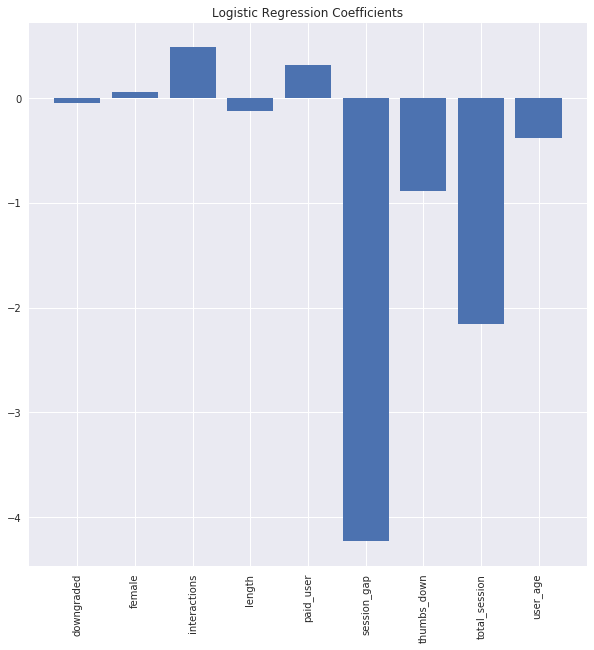

In [131]:
# Get coefficients
lr_corr = lrmodel.bestModel.stages[-1].coefficients
plt.bar(list_feats,lr_corr)
plt.xticks(rotation='vertical')
plt.title('Logistic Regression Coefficients')
plt.show()

### Random Forest Tuning

In [44]:
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth,[5,10,20])\
    .addGrid(rf.numTrees,[20,30])\
    .build()

In [ ]:
rfmodel, rfresults = fit_model(rf, paramGrid = rf_paramGrid)

In [ ]:
brf_index = rfmodel.avgMetrics.index(np.max(rfmodel.avgMetrics))
brf = rf_paramGrid[brf_index]
print(brf)

In [ ]:
print("RandomForest: accuracy,precision,recall", val_evaluation(rfresults))

In [117]:
# Extract feature importance from rfmodel
featImportances = np.array(rfmodel.bestModel.stages[-1].featureImportances)

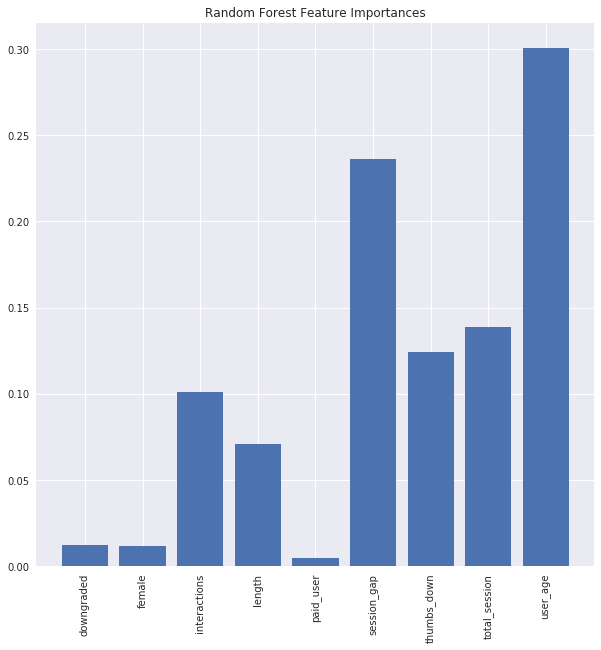

In [132]:
plt.bar(list_feats,featImportances)
plt.xticks(rotation='vertical')
plt.title('Random Forest Feature Importances')
plt.show()